<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw3/part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### HW3-Part 2

### Sources

Paper

https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html#

Codes

https://proceedings.neurips.cc/paper/2015/file/33ceb07bf4eeb3da587e268d663aba1a-Paper.pdf

https://pypi.org/project/elasticdeform/

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Qn #1

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

##Loading the data

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Depicting spatial transformer networks

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the Model

In [67]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_accu = []
train_losses = []

def train(epoch):
    
    model.train()

    running_loss=0
    correct=0
    total=0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        running_loss += loss.item()

        _, predicted = output.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
    train_accu.append(accu)
    train_losses.append(train_loss)
    


test_losses=[]
test_accu=[]

def test():
    correct = 0
    running_loss=0
    total=0

    with torch.no_grad():
        model.eval()
        test_loss = 0
        # correct = 0

        # running_loss=0
        # total=0

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            _, predicted = output.max(1)
            total += target.size(0)
            # correct += predicted.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    test_losses.append(test_loss)
    test_accu.append(accu)

##Visualizing the STN results

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.038590
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.135567


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0351, Accuracy: 9900/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007961
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.111409

Test set: Average loss: 0.0311, Accuracy: 9913/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.015413
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.018643

Test set: Average loss: 0.0358, Accuracy: 9905/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.044257
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.068838

Test set: Average loss: 0.0320, Accuracy: 9916/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.058338
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.061836

Test set: Average loss: 0.0337, Accuracy: 9900/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.097923
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.009009

Test set: Average loss: 0.0354, Accuracy: 9898/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.241371
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.098834

Test set: Average loss: 0.0357, Accuracy: 9907/10000 (99%)

Tra

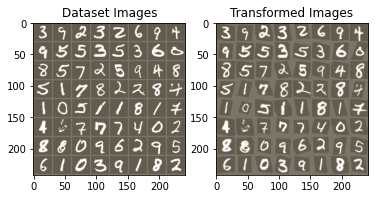

In [68]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

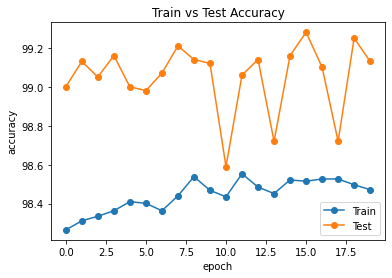

In [71]:
plt.plot(train_accu,'-o')
plt.plot(test_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')

plt.show()

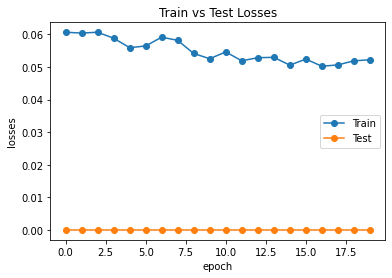

In [72]:
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')

plt.show()

# Qn #2

In [15]:
!pip install elasticdeform

In [20]:
import numpy, imageio, elasticdeform


In [21]:
# this block of code is adapted from Reid's post via discord


'''
Train Data
'''


# load the original train data
train_original = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
    # transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

# randomize the train data
train_random = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
    transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

# zoom the train data
train_zoom = datasets.MNIST(
    root='.', train=True, download=True, transform=transforms.Compose([
    transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3, zoom=4)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)


'''
Train Data
'''


# load the original test data
test_original = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
    # transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

# randomize the train data
test_random = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
    transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

# zoom the train data
test_zoom = datasets.MNIST(
    root='.', train=False, download=True, transform=transforms.Compose([
    transforms.Lambda(lambda x: elasticdeform.deform_random_grid(np.array(x), sigma=25, points=3, zoom=4)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]),
)

In [22]:
df_train = torch.utils.data.ConcatDataset([train_original, train_random, train_zoom])

df_train_loader = torch.utils.data.DataLoader(df_train, batch_size=64, num_workers=12, persistent_workers=True,
                                              shuffle=True, pin_memory=True)

df_test = torch.utils.data.ConcatDataset([test_original, test_random, test_zoom])

df_test_loader = torch.utils.data.DataLoader(df_test, batch_size=64, num_workers=12, persistent_workers=True,
                                              shuffle=True, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training and Visualization

In [23]:
# optimizer = optim.SGD(model.parameters(), lr=0.01)


# def train(epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(df_train_loader):
#         data, target = data.to(device), target.to(device)

#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 500 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(df_train_loader.dataset),
#                 100. * batch_idx / len(df_train_loader), loss.item()))


# def test():
#     with torch.no_grad():
#         model.eval()
#         test_loss = 0
#         correct = 0
#         for data, target in df_test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)

#             # sum up batch loss
#             test_loss += F.nll_loss(output, target, size_average=False).item()
#             # get the index of the max log-probability
#             pred = output.max(1, keepdim=True)[1]
#             correct += pred.eq(target.view_as(pred)).sum().item()

#         test_loss /= len(df_test_loader.dataset)
#         print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
#               .format(test_loss, correct, len(df_test_loader.dataset),
#                       100. * correct / len(df_test_loader.dataset)))


optimizer = optim.SGD(model.parameters(), lr=0.01)

train_accu = []
train_losses = []

def train(epoch):
    
    model.train()

    running_loss=0
    correct=0
    total=0

    
    for batch_idx, (data, target) in enumerate(df_train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(df_train_loader.dataset),
                100. * batch_idx / len(df_train_loader), loss.item()))
            
        running_loss += loss.item()

        _, predicted = output.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss=running_loss/len(df_train_loader)
    accu=100.*correct/total
    train_accu.append(accu)
    train_losses.append(train_loss)
    


test_losses=[]
test_accu=[]

def test():
    correct = 0
    running_loss=0
    total=0

    with torch.no_grad():
        model.eval()
        test_loss = 0
        # correct = 0

        # running_loss=0
        # total=0

        for data, target in df_test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            _, predicted = output.max(1)
            total += target.size(0)
            # correct += predicted.eq(target).sum().item()

        test_loss /= len(df_test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(df_test_loader.dataset),
                      100. * correct / len(df_test_loader.dataset)))
        
    test_loss=running_loss/len(df_test_loader)
    accu=100.*correct/total

    test_losses.append(test_loss)
    test_accu.append(accu)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify al

Train Epoch: 1 [0/180000 (0%)]	Loss: 2.300663
Train Epoch: 1 [32000/180000 (18%)]	Loss: 2.207830
Train Epoch: 1 [64000/180000 (36%)]	Loss: 2.054712
Train Epoch: 1 [96000/180000 (53%)]	Loss: 1.892022
Train Epoch: 1 [128000/180000 (71%)]	Loss: 1.936262
Train Epoch: 1 [160000/180000 (89%)]	Loss: 1.747717


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.6332, Accuracy: 12062/30000 (40%)

Train Epoch: 2 [0/180000 (0%)]	Loss: 1.915067
Train Epoch: 2 [32000/180000 (18%)]	Loss: 1.815193
Train Epoch: 2 [64000/180000 (36%)]	Loss: 1.708679
Train Epoch: 2 [96000/180000 (53%)]	Loss: 1.658596
Train Epoch: 2 [128000/180000 (71%)]	Loss: 1.643442
Train Epoch: 2 [160000/180000 (89%)]	Loss: 1.503117

Test set: Average loss: 1.5809, Accuracy: 12313/30000 (41%)

Train Epoch: 3 [0/180000 (0%)]	Loss: 1.843598
Train Epoch: 3 [32000/180000 (18%)]	Loss: 1.887187
Train Epoch: 3 [64000/180000 (36%)]	Loss: 1.819512
Train Epoch: 3 [96000/180000 (53%)]	Loss: 1.743015
Train Epoch: 3 [128000/180000 (71%)]	Loss: 1.831554
Train Epoch: 3 [160000/180000 (89%)]	Loss: 1.513558

Test set: Average loss: 1.5684, Accuracy: 12355/30000 (41%)

Train Epoch: 4 [0/180000 (0%)]	Loss: 1.504113
Train Epoch: 4 [32000/180000 (18%)]	Loss: 1.563154
Train Epoch: 4 [64000/180000 (36%)]	Loss: 1.593336
Train Epoch: 4 [96000/180000 (53%)]	Loss: 1.557681
Train Epo

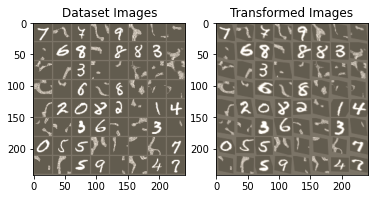

In [24]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(df_test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

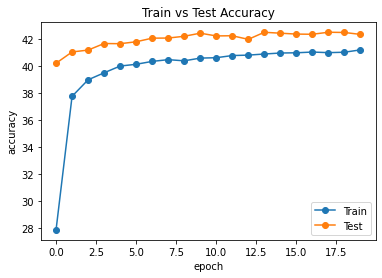

In [25]:
plt.plot(train_accu,'-o')
plt.plot(test_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')

plt.show()

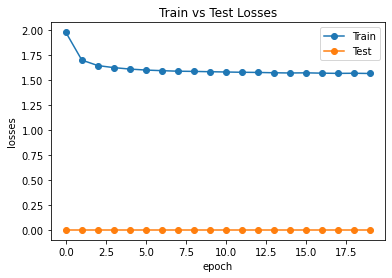

In [26]:
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')

plt.show()